<h1> Elo world </h1>

![Elo](https://www.cloudera.com/content/dam/www/marketing/images/logos/customers/cartao-elo.png)

<h3> 1) Problem Statement : </h3>


> Develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty. 


<h3> 2) Real world/Business Objectives and constraints </h3>

> Predict a loyalty score for credit cards based on historical data and merchant information.

>Some form of interpretability.


<h3> 3) Mapping to an ML problem:Data overview: </h3>

totally we have 5 csv files

> The data is formatted as follows:

> "train.csv" and "test.csv" contain card_ids and information about the card itself."train.csv" also contains the target.

>"historical_transactions.csv" and "new_merchant_transactions.csv" are designed to be joined with "train.csv", "test.csv", and "merchants.csv". 
They contain information about transactions for each card, as described above.

>"merchants" can be joined with the transaction sets to provide additional merchant-level information.

Performance metric :

>Root Mean Square Error

We'll be using the root mean squared error as our evaluation metric:

$$
RMSE(y, \hat{y}) = \sqrt{ \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2 }
$$


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

<h2> Memory usage </h2>

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<h3> 4) Reading Data </h3>

<h3> 4.1) Reading `train_data` </h3>

In [22]:
e = pd.read_excel('Data_Dictionary.xlsx', sheet_name='train')
e

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


-Looks like, we have 3 categorical features `feature_1`, `feature_2` & `feature_3`.



-`first_active_month` will be helpful in extracting date features



-`target` is a label

In [23]:
%time
train_data =pd.read_csv("train.csv", parse_dates=['first_active_month'])
print('Number of data points : ', train_data.shape[0])
print('Number of features : ', train_data.shape[1])
print('Features : ', train_data.columns.values)
train_data.head()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs
Number of data points :  201917
Number of features :  6
Features :  ['first_active_month' 'card_id' 'feature_1' 'feature_2' 'feature_3'
 'target']


,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [24]:
train_data = train_data.drop_duplicates()
print('Number of points after removing duplicates  :', train_data.shape[0])

Number of points after removing duplicates  : 201917


In [25]:
#Visualizing Null data in Dataframe
#https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation
%time
train_data.isnull().sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

There are no Null values in `train_data`.

In [26]:
#checking unique values in each feature
train_data['feature_1'].unique()

array([5, 4, 2, 1, 3])

In [27]:
#checking unique values in each feature
train_data['feature_2'].unique()

array([2, 1, 3])

In [28]:
#checking unique values in each feature
train_data['feature_3'].unique()

array([1, 0])

In [29]:
# Convert first_active_month to datetime
train_data['first_active_month'] = pd.to_datetime(train_data['first_active_month'],
                                             format='%Y-%m')

<h3> 4.2) Reading `test_data` </h3>

In [30]:
%time
test_data =pd.read_csv("test.csv" , parse_dates=["first_active_month"])
print('Number of data points : ', test_data.shape[0])
print('Number of features : ', test_data.shape[1])
print('Features : ', test_data.columns.values)
test_data.head()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs
Number of data points :  123623
Number of features :  5
Features :  ['first_active_month' 'card_id' 'feature_1' 'feature_2' 'feature_3']


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


In [31]:
test_data = test_data.drop_duplicates()
print('Number of points after removing duplicates  :', test_data.shape[0])

Number of points after removing duplicates  : 123623


In [32]:
#Visualizing Null data in Dataframe
#https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation
%time
test_data.isnull().sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [33]:
#Checking for any possible Null values
test_data[test_data.isnull().any(axis=1)]

,first_active_month,card_id,feature_1,feature_2,feature_3
11578,NaT,C_ID_c27b4f80f7,5,2,1


We have a Null value present in the month row, therefore this doesn't contribute much to the model performance. Retaining it doesn't contribute either.

so, we are dropping this line from the dataset.

In [34]:
#test_data = test_data.dropna(how='any',axis=0) 
#Removing Nan values from feature
test_data = test_data.drop(test_data.loc[test_data['first_active_month'].isnull()].index)

In [35]:
#Saving the latest copy which has all the data, converted in to csv format
test_data.to_csv('test_elo.csv')

<h3> Exploratory Data Analysis </h3>

<h3> Exploratory Data Analysis - Train & Test dataset </h3>

<h4> `Target` </h4>

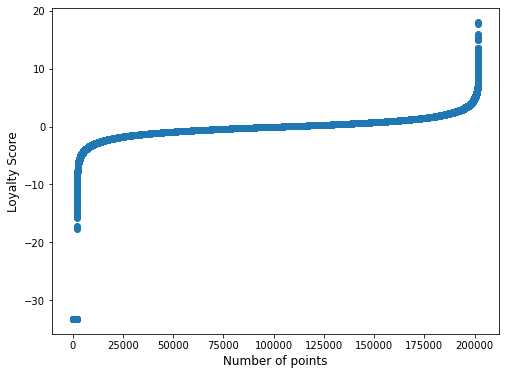

In [36]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
target_col = "target"
plt.figure(figsize=(8,6))
plt.scatter(range(train_data.shape[0]), np.sort(train_data[target_col].values))
plt.xlabel('Number of points', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

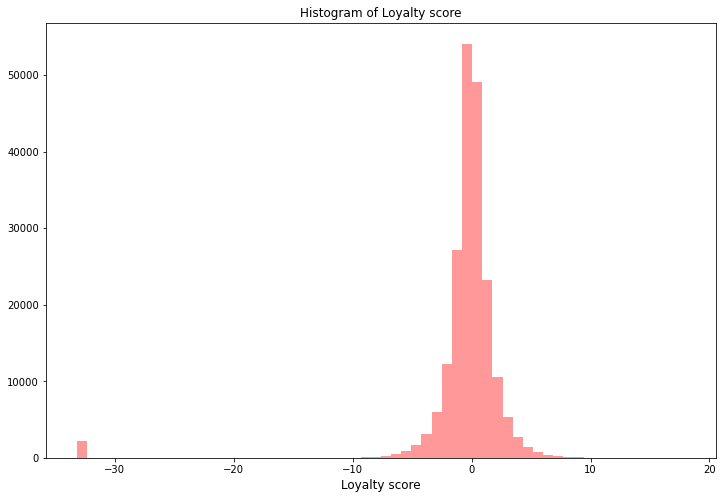

In [37]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
plt.figure(figsize=(12,8))
sns.distplot(train_data[target_col].values, bins=60, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

it is evident from the above graph, most of the loyalty scores in the range of -10 to 10.

looks like there are some potential numbers of loyalty scores in -30, may be they were outliers.

In [38]:
(train_data[target_col]<-30).sum()

2207

<h4> Percentiles </h4>

Since, we have few outliers when the data is posed on Histogram.

Let us use percentiles to trace its exact origin.

In [39]:
#Calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =train_data[target_col].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -33.21928095
10 percentile value is -2.04231327
20 percentile value is -1.14604394
30 percentile value is -0.66396308
40 percentile value is -0.31220831
50 percentile value is -0.02343689
60 percentile value is 0.23620054
70 percentile value is 0.56450565
80 percentile value is 1.01425572
90 percentile value is 1.83029589
100 percentile value is  17.9650684


Value at zeroth percentile looks strange. 
Let us check its origin deeply

Looks, like 100th percentile value looks slight deviation from the rest of the points.

In [40]:
#Looking further from the 1st percecntile
for i in range(1,11):
    var =train_data[target_col].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
#print ("10 percentile value is ",var[-1])

1 percentile value is -33.21928095
2 percentile value is -5.01608376
3 percentile value is -4.06331826
4 percentile value is -3.49376358
5 percentile value is -3.10796501
6 percentile value is -2.80808288
7 percentile value is -2.56256564
8 percentile value is -2.36228882
9 percentile value is -2.19336416
10 percentile value is -2.04231327


clearly looks like an outlier from the above percentiles.

Therefore, total number of data points present was 201917, out of which 2207 were found out to be outliers.

In [41]:
#removing further outliers based on the 1st percentile value
train_df=train_data[(train_data[target_col]>-5) & (train_data[target_col]<18)]
train_df.shape[0]

197848

<h4> `first_active_month` </h4>

<h5> Train data : </h5>

In [42]:
#start date of a training dataset
train_df["first_active_month"].min()

Timestamp('2011-11-01 00:00:00')

In [43]:
#End date of a training dataset
train_df["first_active_month"].max()

Timestamp('2018-02-01 00:00:00')

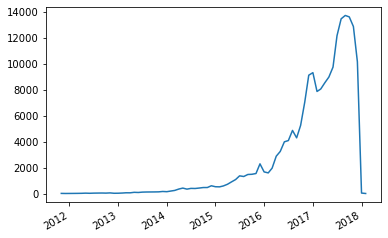

In [44]:
train_df["first_active_month"].value_counts().plot()

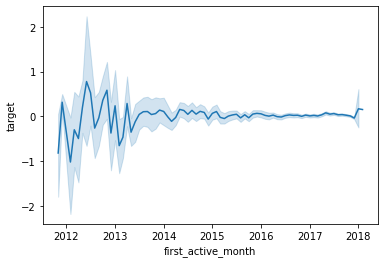

In [45]:
# first_active_month vs loyalty score
sns.lineplot(x='first_active_month', y='target', data=train_df)
plt.show()

From the above graph, it is evident that Loyalty scores improve gradually over a period of time. 

And takes a steady steep, post 2014.

<h5> Test data: </h5>

In [46]:
#start date of a test dataset
test_data["first_active_month"].min()

Timestamp('2011-11-01 00:00:00')

In [47]:
#End date of a test dataset
test_data["first_active_month"].max()

Timestamp('2018-01-01 00:00:00')

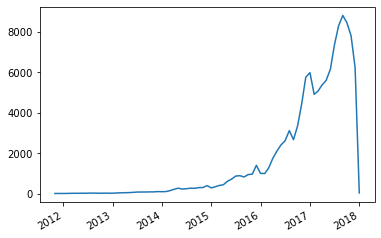

In [48]:
test_data["first_active_month"].value_counts().plot()

Both the distributions of "first_active_month"  for train and test data looks similar.

<h4>  `feature_1`, `feature_2` & `feature_3` </h4>

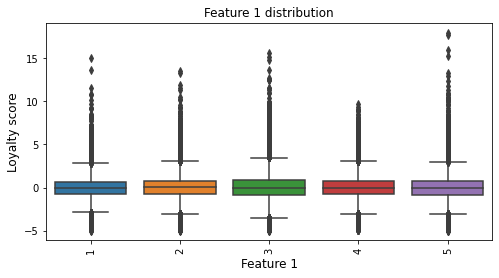

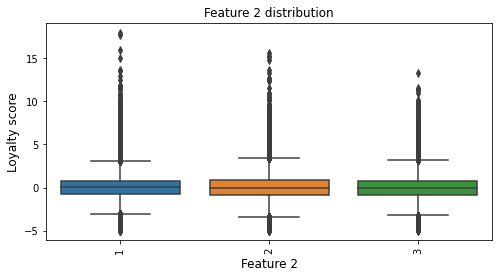

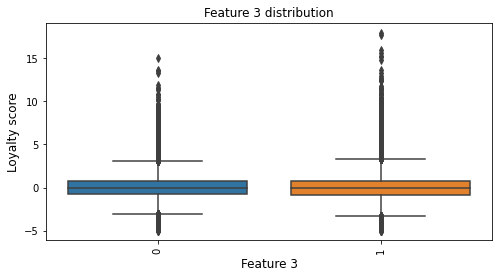

In [31]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# feature 1
plt.figure(figsize=(8,4))
sns.boxplot(x="feature_1", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.boxplot(x="feature_2", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.boxplot(x="feature_3", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

Even the distributions of 3 features were looks similar.

Therefore, it is evident that from the above plots the dataset has some outliers. If we remove the outliers the dataset looks imbalance and to overcome this we have to use oversampling and then pose the problem as classification teachnique to solve this.

Now, without considering the outliers the dataset looks like a regression model and if we apply any one of the baseline models and selects the best model.

Our approach on this problem is:

1) Apply linear regression baseline models to achieve less RMSE value

2) Remove outliers and apply oversampling on top of it and slove it by a classification technique.

Till now we have visualise Train and Test csv files,

Now, let us visualise the rest of the features from the other csv files.

<h3> 4.3) Reading `historical transactions` </h3>

In [5]:
e = pd.read_excel('Data_Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


`category_1`, `category_2`, `category_3` are categotical features.


Since, few of the line itmes in category features have nan values..Now, let us convert this in to numerical features and look for any similarities between the features. If the features looks similar then we are dropping this off from the dataset and if the features are different we continue to add this in the dataset.

In [6]:
%time
hist = pd.read_csv('historical_transactions.csv')
print('Number of data points : ', hist.shape[0])
print('Number of features : ', hist.shape[1])
print('Features : ', hist.columns.values)
hist.head()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs
Number of data points :  29112361
Number of features :  14
Features :  ['authorized_flag' 'card_id' 'city_id' 'category_1' 'installments'
 'category_3' 'merchant_category_id' 'merchant_id' 'month_lag'
 'purchase_amount' 'purchase_date' 'category_2' 'state_id' 'subsector_id']


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [8]:
hist = hist.drop_duplicates()
print('Number of points after removing duplicates  :', hist.shape[0])

Number of points after removing duplicates  : 29112361


Seems like there are no duplicates present in 'hist' dataframe.

In [9]:
#Visualizing Null data in Dataframe
#https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation
%time
hist.isnull().sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

Seems like `category 2`, `category_3` and `Merchant_id` has  null values.

In [10]:
#Removing Nan values from feature
hist = hist.drop(hist.loc[hist['merchant_id'].isnull()].index)
print('Number of points after removing from Merchant ID  :', hist.shape[0])

Number of points after removing from Merchant ID  : 28973880


Merchant_id can never be an empty or Nan.. This should have an ID, without an ID the transactions might look meaningless. So, I have removed the transactions beloging to Nan in Merchant_id.

In [11]:
#Installments
hist['installments'].value_counts()

 0      15336465
 1      11621828
 2        666348
 3        538099
 4        179497
-1        170952
 6        132609
 10       118818
 5        116046
 12        55056
 8         20471
 7         10902
 9          5771
 11          830
 999         188
Name: installments, dtype: int64

Here we have a hiccup, installments starts from the range of 0-11 months.

But here we have -1 and 999 looks strange.

This might be a false transactions.

In [12]:
# let's convert the authorized_flag to a binary value.
hist['authorized_flag'] = hist['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [13]:
# you dont need this
hist.groupby(['installments'])['authorized_flag'].mean()

installments
-1      0.888612
 0      0.928268
 1      0.907247
 2      0.884101
 3      0.862425
 4      0.820030
 5      0.809472
 6      0.779857
 7      0.693451
 8      0.692541
 9      0.663836
 10     0.702065
 11     0.660241
 12     0.653753
 999    0.031915
Name: authorized_flag, dtype: float64

In [14]:
#removing further outliers based on the 1st percentile value
hist_f=hist[(hist['installments']>0) & (hist['installments']<12)]
hist_f.shape[0]

13411219

In [42]:
#Visualizing Null data in Dataframe
#https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation
%time
hist_f.isnull().sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3                    0
merchant_category_id          0
merchant_id                   0
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2229333
state_id                      0
subsector_id                  0
dtype: int64

In [43]:
#checking total categories in a feature
hist_f['category_2'].unique()

array([ 3.,  1.,  5.,  2., nan,  4.])

In [44]:
hist_f[hist_f['category_2'].isnull()].head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
418,1,C_ID_5037ff576e,-1,N,1,B,307,M_ID_d8281a0ff9,-11,-0.303581,2017-01-07 10:17:04,NaN,-1,19
425,1,C_ID_5037ff576e,-1,N,1,B,307,M_ID_949996e6b5,0,-0.671775,2017-12-24 19:28:09,NaN,-1,19
430,1,C_ID_5037ff576e,-1,N,1,B,307,M_ID_fe69229f24,-1,0.189755,2017-11-23 00:00:00,NaN,-1,19


from above, it is evident that card_id has some duplicates. Let us remove the duplicate based on Merhcant_id, Purchase_amount and Purchase_date .specifically why we have chosen Merchant_id over card_id just because an user can do the transaction on multiple merchants and there should be any repeated Merchant_id and card_id for the same transaction on mutliple times. This logic we have deployed here.

In [15]:
hist_f=hist_f.drop_duplicates(subset=['merchant_id','purchase_amount','purchase_date'], keep="first")
hist_f.shape[0]

13383837

In [46]:
hist_f.head(6)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
400,0,C_ID_5037ff576e,322,N,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37
401,1,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19
402,1,C_ID_5037ff576e,138,N,1,B,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1.0,15,33
403,1,C_ID_5037ff576e,226,N,1,B,307,M_ID_708022307c,-4,-0.652256,2017-08-15 10:45:28,1.0,16,19
404,1,C_ID_5037ff576e,330,N,1,B,705,M_ID_393b4b8cec,-9,-0.674210,2017-03-26 20:00:31,3.0,17,33
405,1,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-9,-0.671775,2017-03-09 18:32:05,1.0,15,19


Since, we have few 'nan' values in category-2. we can't remove this completely off from the dataframe as it may carry some valuable information such as purchase amount. so, we are just replacing the nan values by taking the weightage of the complete category with it's mean.

Hope this might do the trick well!!

In [16]:
#https://stackoverflow.com/questions/57577188/replace-nan-values-by-user-defined-values-in-categorical-variables
#replacing category_2 which has Null values using user defined values
p = hist_f.category_2.value_counts(normalize=True)  # Series of probabilities
m = hist_f.category_2.isnull()

np.random.seed(42)
rand_fill = np.random.choice(p.index, size=m.sum(), p=p)

hist_f.loc[m, 'category_2'] = rand_fill

In [17]:
hist_f.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
400,0,C_ID_5037ff576e,322,N,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37
401,1,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19
402,1,C_ID_5037ff576e,138,N,1,B,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1.0,15,33


#converting Categoical features in to Numerical

In [18]:
#converting boolean features in to Numerical
#https://datascience.stackexchange.com/questions/42465/do-i-need-to-convert-booleans-to-ints-to-enter-them-in-a-machine-learning-algori
#hist_f['authorized_flag'] = hist_f['authorized_flag'].map({'Y': 1, 'N': 0})
hist_f['category_3'] = hist_f['category_3'].map({'A': 0, 'B': 1, 'C':2})

In [19]:
#converting boolean features in to Numerical
#https://datascience.stackexchange.com/questions/42465/do-i-need-to-convert-booleans-to-ints-to-enter-them-in-a-machine-learning-algori
#hist_f['authorized_flag'] = hist_f['authorized_flag'].map({'Y': 1, 'N': 0})
hist_f['category_1'] = hist_f['category_1'].map({'Y': 1, 'N': 0})

In [20]:
#hist_f['category_3']=category_3
hist_f.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
400,0,C_ID_5037ff576e,322,0,1,1,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37
401,1,C_ID_5037ff576e,138,0,1,1,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19
402,1,C_ID_5037ff576e,138,0,1,1,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1.0,15,33
403,1,C_ID_5037ff576e,226,0,1,1,307,M_ID_708022307c,-4,-0.652256,2017-08-15 10:45:28,1.0,16,19
404,1,C_ID_5037ff576e,330,0,1,1,705,M_ID_393b4b8cec,-9,-0.674210,2017-03-26 20:00:31,3.0,17,33


<h3> EDA on "Historical_transactions".csv </h3>

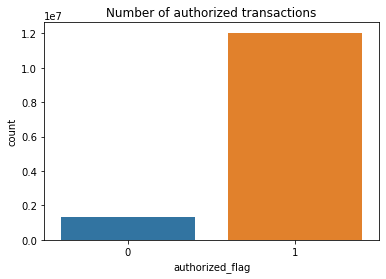

In [53]:
#Authorised flag
sns.countplot(x='authorized_flag', data=hist_f)
plt.title('Number of authorized transactions')
plt.show()

seems like, most of the transactions were Authorized.

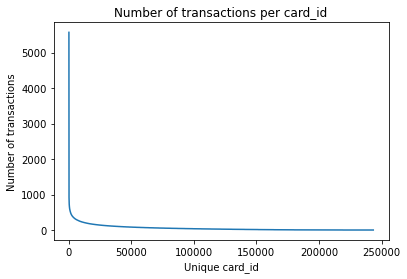

In [54]:
# card_id
plt.plot(hist_f['card_id'].value_counts().values)
plt.xlabel('Unique card_id')
plt.ylabel('Number of transactions')
plt.title('Number of transactions per card_id')
plt.show()

seems like very few card_id has the most number of transactions

In [55]:
hist_f['purchase_date'] = pd.to_datetime(hist_f['purchase_date'])

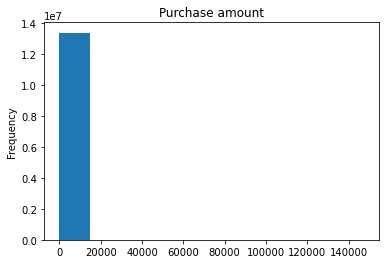

In [56]:
#Purchase_amount
plt.title('Purchase amount');
hist_f['purchase_amount'].plot(kind='hist');

Looks like Purchase amount is Normalised.

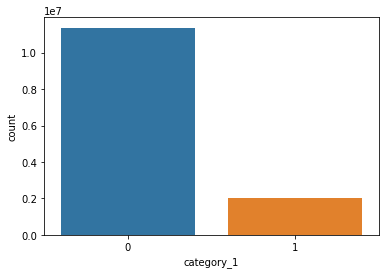

In [57]:
#from matplotlib.ticker import FormatStrFormatter
# category_1
sns.countplot(x='category_1', data=hist_f)
plt.show()


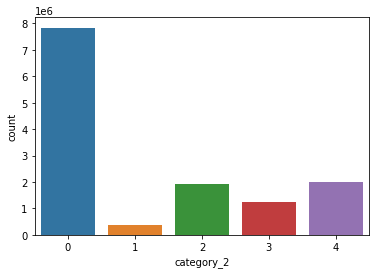

In [58]:
# category_2
from matplotlib.ticker import FormatStrFormatter
sns.countplot(x='category_2', data=hist_f)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

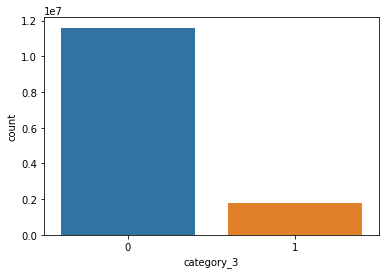

In [59]:
# category_3
sns.countplot(x='category_3', data=hist_f)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

Initially, we have 3 categories before removing the outliers from 'installments'.

we are left with 2 categories post removing the outliers from 'installments'.

All the Categories are quite different.

Other categorical data are:

In [60]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {hist_f[col].nunique()} unique values in {col}.")

There are 308 unique values in city_id.
There are 323 unique values in merchant_category_id.
There are 281886 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


In [61]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [49]:
#select-certain-rows-by-column value-of-another-dataframe
#https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe/12098586#12098586
sample_1=hist_f[hist_f['card_id'].isin(train_df['card_id'])]
print('Number of historical transaction data points were present in train_data  :', sample_1.shape[0])
print('Total Number of points in historical transacions  :',hist_f.shape[0])

Number of historical transaction data points were present in train_data  : 8091684
Total Number of points in historical transacions  : 13383837


In [50]:
hist_f=sample_1
hist_f.shape[0]

8091684

In [51]:
del sample_1

In [52]:
%time
hist_data = reduce_mem_usage(hist_f)
del hist_f
#gc.collect()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs
Mem. usage decreased to 378.12 Mb (59.2% reduction)


In [53]:
train = reduce_mem_usage(train_df)
del train_df
#gc.collect()

Mem. usage decreased to  5.47 Mb (48.2% reduction)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [54]:
%time
train_f = pd.merge(train, hist_data, on='card_id', how='left')
#test = pd.merge(test_data, hist, on='card_id', how='left')
del hist_data
del train

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs


In [55]:
del hist
del train_data

In [56]:
#saving the final model in to 'train_f.csv'
train_f.to_csv('train_f.csv')

<h3> 4.4)Reading `new_merchant_transactions` </h3>

In [57]:
e = pd.read_excel('Data_Dictionary.xlsx', sheet_name='new_merchant_period')
e

,new_merchant_period.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


`category_1`, `category_2`, `category_3` are categotical features.

Even feature `installments` looks like a categorical one, all the installments range between 0-11 months.

In [58]:
%time
new_merch =pd.read_csv("new_merchant_transactions.csv")
print('Number of data points : ', new_merch.shape[0])
print('Number of features : ', new_merch.shape[1])
print('Features : ', new_merch.columns.values)

new_merch.head(3)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs
Number of data points :  1963031
Number of features :  14
Features :  ['authorized_flag' 'card_id' 'city_id' 'category_1' 'installments'
 'category_3' 'merchant_category_id' 'merchant_id' 'month_lag'
 'purchase_amount' 'purchase_date' 'category_2' 'state_id' 'subsector_id']


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14


In [59]:
new_merch = new_merch.drop_duplicates()
print('Number of points after removing duplicates  :', new_merch.shape[0])

Number of points after removing duplicates  : 1963031


Seems like `category 2`, `category_3` and `Merchant_id` has  null values.

In [60]:
#Removing Nan values from feature
new_merch = new_merch.drop(new_merch.loc[new_merch['merchant_id'].isnull()].index)
print('Number of points after removing from merchant_id  :', new_merch.shape[0])

Number of points after removing from merchant_id  : 1936815


Merchant_id can never be an empty or Nan.. This should have an ID, without an ID the transactions might look meaningless. So, I have removed the transactions beloging to Nan in Merchant_id.

Merchant_id and card_id are the unique fields that shouldn't be empty.

In [74]:
#Installments
new_merch['installments'].value_counts()

 0      909084
 1      825304
 2       54729
-1       53740
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

Here we have a hiccup, installments starts from the range of 0-11 months.

But here we have -1 and 999 looks strange.

This might be a false transactions.

In [61]:
# let's convert the authorized_flag to a binary value.
new_merch['authorized_flag'] = new_merch['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [62]:
#removing further outliers based on the 1st percentile value
new_merch_f=new_merch[(new_merch['installments']>0) & (new_merch['installments']<12)]
new_merch_f.shape[0]

971139

In [77]:
#Visualizing Null data in Dataframe
#https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation
%time
new_merch_f.isnull().sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


authorized_flag             0
card_id                     0
city_id                     0
category_1                  0
installments                0
category_3                  0
merchant_category_id        0
merchant_id                 0
month_lag                   0
purchase_amount             0
purchase_date               0
category_2              79135
state_id                    0
subsector_id                0
dtype: int64

In [78]:
#checking total categories in a feature
new_merch_f['category_2'].unique()

array([ 1., nan,  2.,  5.,  4.,  3.])

In [79]:
new_merch_f[new_merch_f['category_2'].isnull()].head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
3,1,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
14,1,C_ID_ef55cf8d4b,-1,Y,1,B,302,M_ID_b9f9332438,1,-0.665539,2018-03-23 21:35:53,NaN,-1,22


from above, it is evident that card_id has some duplicates. Let us remove the duplicate based on Merhcant_id, Purchase_amount and Purchase_date .specifically why we have chosen Merchant_id over card_id just because an user can do the transaction on multiple merchants and there should be any repeated Merchant_id and card_id for the same transaction on mutliple times. This logic we have deployed here.

In [63]:
new_merch_f=new_merch_f.drop_duplicates(subset=['merchant_id','purchase_amount','purchase_date'], keep="first")
new_merch_f.shape[0]

971128

In [81]:
new_merch_f.head(6)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
5,1,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,1.0,9,16


Since, we have few 'nan' values in category-2. we can't remove this completely off from the dataframe as it may carry some valuable information such as purchase amount. so, we are just replacing the nan values by taking the weightage of the complete category with it's mean.

Hope this might do the trick well!!

In [64]:
#https://stackoverflow.com/questions/57577188/replace-nan-values-by-user-defined-values-in-categorical-variables
#replacing category_2 which has Null values using user defined values
p = new_merch_f.category_2.value_counts(normalize=True)  # Series of probabilities
m = new_merch_f.category_2.isnull()

np.random.seed(42)
rand_fill = np.random.choice(p.index, size=m.sum(), p=p)

new_merch_f.loc[m, 'category_2'] = rand_fill

In [83]:
new_merch_f.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14


#converting Categoical features in to Numerical

In [65]:
#converting boolean features in to Numerical
#https://datascience.stackexchange.com/questions/42465/do-i-need-to-convert-booleans-to-ints-to-enter-them-in-a-machine-learning-algori
#hist_f['authorized_flag'] = hist_f['authorized_flag'].map({'Y': 1, 'N': 0})
new_merch_f['category_3'] = new_merch_f['category_3'].map({'A': 0, 'B': 1, 'C':2})

In [66]:
#converting boolean features in to Numerical
#https://datascience.stackexchange.com/questions/42465/do-i-need-to-convert-booleans-to-ints-to-enter-them-in-a-machine-learning-algori
#new_merch['authorized_flag'] = new_merch['authorized_flag'].map({'Y': 1, 'N': 0})
new_merch_f['category_1'] = new_merch_f['category_1'].map({'Y': 1, 'N': 0})

In [86]:
#new_merch['category_3']=cat2_ohe
new_merch_f.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19


Seems like, we have Null values present in `caegory-2`,`category-3` & `Merchant_id`.

<h3> EDA on `New_merchants.csv` </h3>

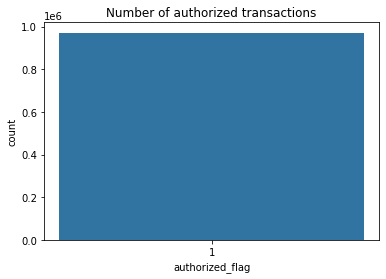

In [88]:
#Authorised flag
sns.countplot(x='authorized_flag', data=new_merch_f)
plt.title('Number of authorized transactions')
plt.show()

in this, all the transactions were authorised.

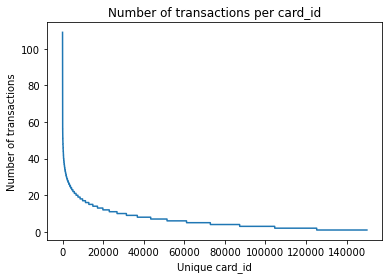

In [89]:
# card_id
plt.plot(new_merch_f['card_id'].value_counts().values)
plt.xlabel('Unique card_id')
plt.ylabel('Number of transactions')
plt.title('Number of transactions per card_id')
plt.show()

very few customers made multiple transactions, where as majority of the transactions were below less than 20 by the customers.

In [91]:
new_merch_f['purchase_date'] = pd.to_datetime(new_merch_f['purchase_date'])

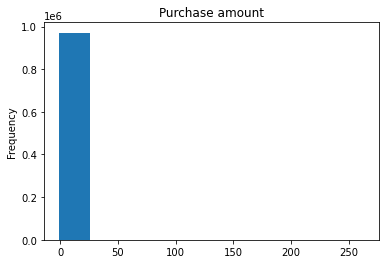

In [92]:
#Purchase_amount
plt.title('Purchase amount');
new_merch_f['purchase_amount'].plot(kind='hist');

Looks like Purchase amount is Normalised

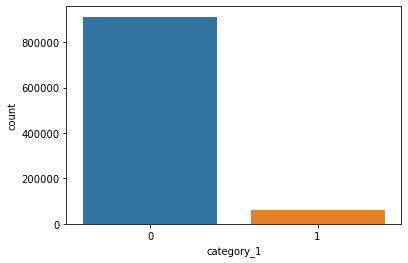

In [93]:
#from matplotlib.ticker import FormatStrFormatter
# category_1
sns.countplot(x='category_1', data=new_merch_f)
plt.show()


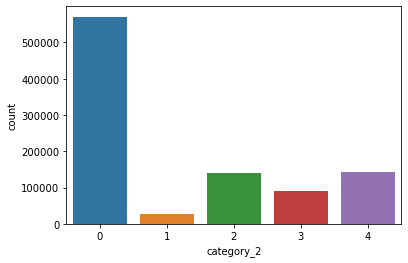

In [94]:
# category_2
from matplotlib.ticker import FormatStrFormatter
sns.countplot(x='category_2', data=new_merch_f)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

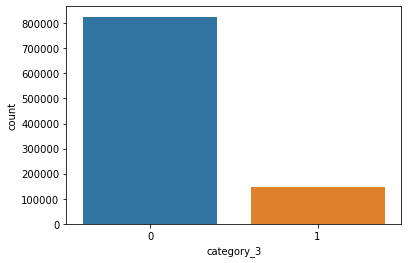

In [95]:
# category_3
sns.countplot(x='category_3', data=new_merch_f)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

All the 3 categories are quite different

Other categorical data are:

In [96]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {new_merch_f[col].nunique()} unique values in {col}.")

There are 308 unique values in city_id.
There are 302 unique values in merchant_category_id.
There are 165778 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


In [67]:
#select-certain-rows-by-column value-of-another-dataframe
#https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe/12098586#12098586
sample_2 = new_merch_f[new_merch_f['card_id'].isin(train_f['card_id'])]
print('Number of merchant transaction data points were present in train_data  :', sample_2.shape[0])
print('Total Number of points in Merchant transacions  :',new_merch_f.shape[0])

Number of merchant transaction data points were present in train_data  : 593875
Total Number of points in Merchant transacions  : 971128


In [68]:
new_merch_f=sample_2
new_merch_f.shape[0]

593875

In [69]:
del sample_2

In [70]:
%time
new_merchant = reduce_mem_usage(new_merch_f)
del new_merch_f
#gc.collect()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs
Mem. usage decreased to 26.62 Mb (60.8% reduction)


In [72]:
hist_df = pd.concat([train_f,new_merchant],sort=False)

In [103]:
hist_df.tail(3)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
1963021,NaT,C_ID_c0dda9d36b,NaN,NaN,NaN,NaN,1.0,87.0,0.0,1.0,1.0,367.0,M_ID_96e6a85df9,2.0,-0.650879,2018-04-14 09:30:29,3.0,11.0,16.0
1963024,NaT,C_ID_0509e85404,NaN,NaN,NaN,NaN,1.0,322.0,0.0,1.0,1.0,705.0,M_ID_531bc3b325,2.0,-0.182129,2018-04-30 08:57:58,3.0,11.0,33.0
1963028,NaT,C_ID_bd97b86450,NaN,NaN,NaN,NaN,1.0,69.0,0.0,1.0,1.0,278.0,M_ID_9a9ccb6544,1.0,-0.621094,2018-03-05 12:04:56,1.0,9.0,37.0


In [73]:
hist_df.shape,train_f.shape,new_merchant.shape

((8735807, 19), (8141932, 19), (593875, 14))

In [74]:
hist_df=hist_df.drop_duplicates()
hist_df.shape[0]

8735806

In [75]:
hist_df=hist_df.drop_duplicates(subset=['merchant_id','purchase_amount','purchase_date'], keep="first")
hist_df.shape[0]

8685557

In [107]:
%time
hist_df.isnull().sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


first_active_month      593872
card_id                      0
feature_1               593872
feature_2               593872
feature_3               593872
target                  593872
authorized_flag              1
city_id                      1
category_1                   1
installments                 1
category_3                   1
merchant_category_id         1
merchant_id                  1
month_lag                    1
purchase_amount              1
purchase_date                1
category_2                   1
state_id                     1
subsector_id                 1
dtype: int64

In [76]:
hist_df = hist_df.drop(hist_df.loc[hist_df['authorized_flag'].isnull()].index)
hist_df.shape[0]

8685556

In [77]:
#replacing nan with blanks
import numpy as np
hist_df = hist_df.replace(np.nan, '', regex=True)

In [58]:
%time
hist_df.isnull().sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


first_active_month      0
card_id                 0
feature_1               0
feature_2               0
feature_3               0
target                  0
authorized_flag         0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

In [78]:
hist_df.to_csv('hist_df.csv')

<h3> 4.5) Reading `merchants` </h3>

In [0]:
%%time
merch =pd.read_csv("/content/drive/My Drive/Elo Merchant/merchants.csv")
print('Number of data points : ', merch.shape[0])
print('Number of features : ', merch.shape[1])
print('Features : ', merch.columns.values)
merch.head()

Number of data points :  334696
Number of features :  22
Features :  ['merchant_id' 'merchant_group_id' 'merchant_category_id' 'subsector_id'
 'numerical_1' 'numerical_2' 'category_1' 'most_recent_sales_range'
 'most_recent_purchases_range' 'avg_sales_lag3' 'avg_purchases_lag3'
 'active_months_lag3' 'avg_sales_lag6' 'avg_purchases_lag6'
 'active_months_lag6' 'avg_sales_lag12' 'avg_purchases_lag12'
 'active_months_lag12' 'category_4' 'city_id' 'state_id' 'category_2']
CPU times: user 883 ms, sys: 69.3 ms, total: 952 ms
Wall time: 1.11 s


CPU times: user 188 ms, sys: 4.84 ms, total: 193 ms
Wall time: 192 ms


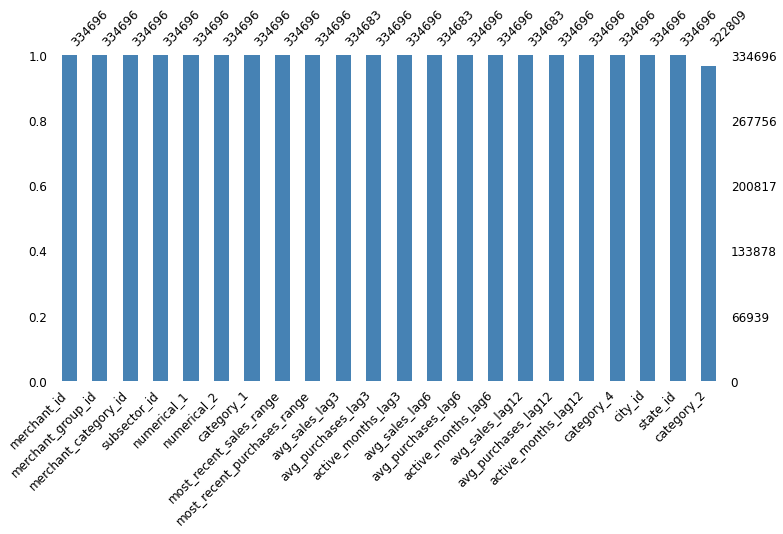

In [0]:
%%time
#Visualizing Null data in Dataframe
#https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation
import missingno as msno
import matplotlib.pyplot as plt
msno.bar(merch, figsize=(12, 6), fontsize=12, color='steelblue')

`avg_sales_lag12`,`avg_sales_lag6` , `avg_sales_lag3` & `category_2` has Null values.

<h2>EDA on Merchants.csv </h2>

In [0]:
merch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

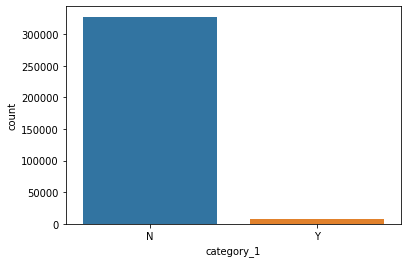

In [0]:
#from matplotlib.ticker import FormatStrFormatter
# category_1
sns.countplot(x='category_1', data=merch)
plt.show()

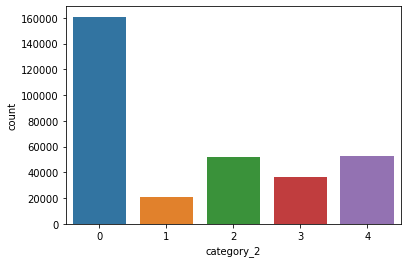

In [0]:
# category_2
from matplotlib.ticker import FormatStrFormatter
sns.countplot(x='category_2', data=merch)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

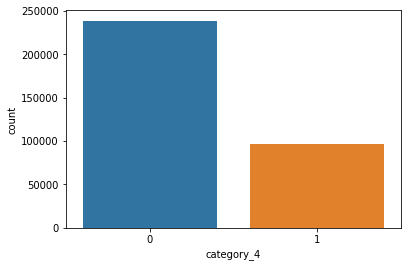

In [0]:
# category_3
sns.countplot(x='category_4', data=merch)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

All the 3 categories looks quite different

<h3> Numerical data </h3>

<h4> Numerical_1 </h4>

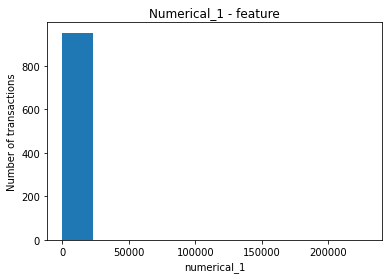

In [0]:
# numerical_1
plt.hist(merch['numerical_1'].value_counts().values)
plt.xlabel('numerical_1')
plt.ylabel('Number of transactions')
plt.title('Numerical_1 - feature')
plt.show()

In [0]:
np.percentile(merch['numerical_1'], 95)

0.09125291

95% of values are less than 0.1

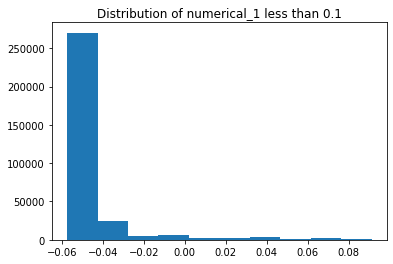

In [0]:
#https://www.kaggle.com/artgor/elo-eda-and-models
plt.hist(merch.loc[merch['numerical_1'] < 0.1, 'numerical_1']);
plt.title('Distribution of numerical_1 less than 0.1');

<h4> Numerical_2 </h4>

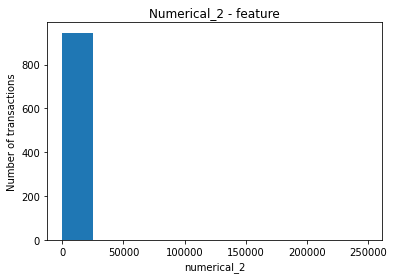

In [0]:
# numerical_2
plt.hist(merch['numerical_2'].value_counts().values)
plt.xlabel('numerical_2')
plt.ylabel('Number of transactions')
plt.title('Numerical_2 - feature')
plt.show()

above plot doesn't help in providing any insight on the data.

In [0]:
np.percentile(merch['numerical_2'], 95)

0.08133801

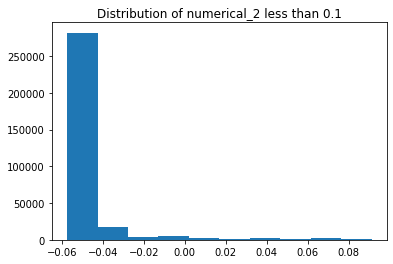

In [0]:
#https://www.kaggle.com/artgor/elo-eda-and-models
plt.hist(merch.loc[merch['numerical_2'] < 0.1, 'numerical_2']);
plt.title('Distribution of numerical_2 less than 0.1');

Both the distributions of `numerical_1` & `numerical_2` looks similar

<h4> most_recent_sales_range </h4>

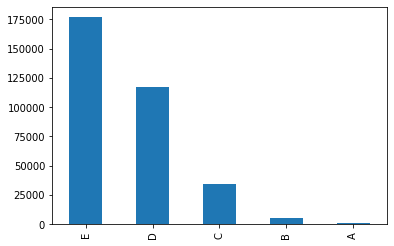

In [0]:
#most_recent_sales_range
merch['most_recent_sales_range'].value_counts().plot('bar');

<h4> most_recent_purchases_range </h4>

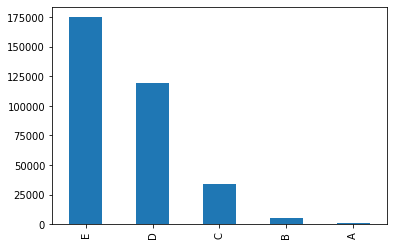

In [0]:
#most_recent_purchases_range
merch['most_recent_purchases_range'].value_counts().plot('bar');

Both the distributions of `most_recent_purchases_range`  & `most_recent_purchases_sales` are similar

<h3> avg_sales_lag </h3>

<h4> avg_sales_lag3 </h4>

In [0]:
for col in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
    print(f'Max value of {col} is {merch[col].max()}')
    print(f'Min value of {col} is {merch[col].min()}')

Max value of avg_sales_lag3 is 851844.64
Min value of avg_sales_lag3 is -82.13
Max value of avg_sales_lag6 is 1513959.0
Min value of avg_sales_lag6 is -82.13
Max value of avg_sales_lag12 is 2567408.0
Min value of avg_sales_lag12 is -82.13


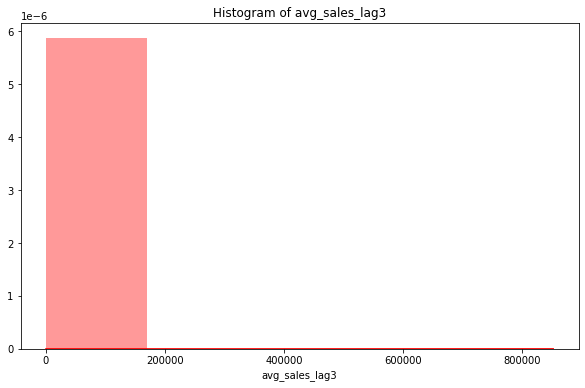

In [0]:
plt.figure(figsize=(10,6))
sns.distplot(merch['avg_sales_lag3'].values, bins=5, color="red")
plt.title("Histogram of avg_sales_lag3")
plt.xlabel('avg_sales_lag3', fontsize=10)
plt.show()

<h4> avg_sales_lag6 </h4>

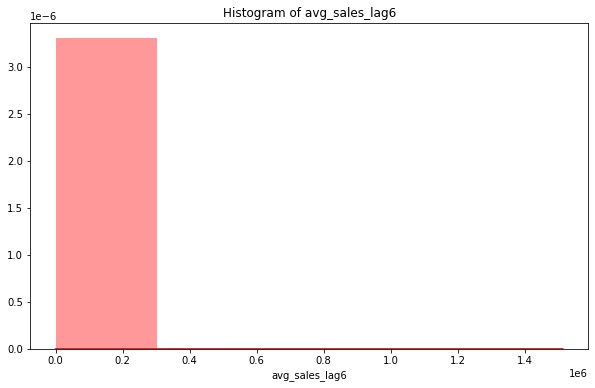

In [0]:
plt.figure(figsize=(10,6))
sns.distplot(merch['avg_sales_lag6'].values, bins=5, color="red")
plt.title("Histogram of avg_sales_lag6")
plt.xlabel('avg_sales_lag6', fontsize=10)
plt.show()

<h4> avg_sales_lag12 </h4>

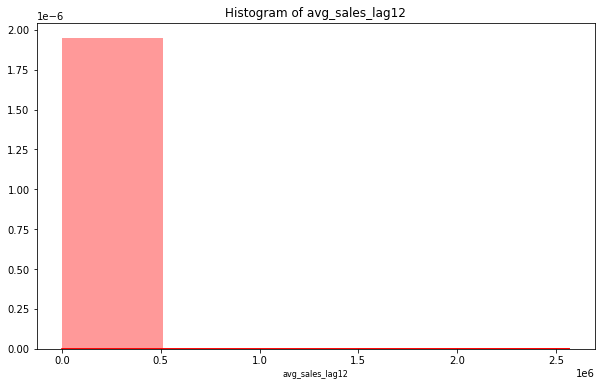

In [0]:
plt.figure(figsize=(10,6))
sns.distplot(merch['avg_sales_lag12'].values, bins=5, color="red")
plt.title("Histogram of avg_sales_lag12")
plt.xlabel('avg_sales_lag12', fontsize=8)
plt.show()

data in the columns of `avg_sales_lag12`, `avg_sales_lag3` & `avg_sales_lag6` are Normalised.

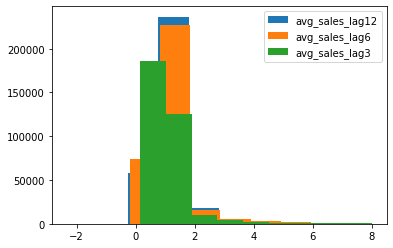

In [0]:
#https://www.kaggle.com/artgor/elo-eda-and-models
plt.hist(merch.loc[(merch['avg_sales_lag12'] < 8) & (merch['avg_sales_lag12'] > -10), 'avg_sales_lag12'], label='avg_sales_lag12');
plt.hist(merch.loc[(merch['avg_sales_lag6'] < 8) & (merch['avg_sales_lag6'] > -10), 'avg_sales_lag6'], label='avg_sales_lag6');
plt.hist(merch.loc[(merch['avg_sales_lag3'] < 8) & (merch['avg_sales_lag3'] > -10), 'avg_sales_lag3'], label='avg_sales_lag3');
plt.legend();

More or less, all the distributions looks similar(each feature is overlapping with each other).

<h3> avg_purchases_lag </h3>

<h4> `avg_purchases_lag3`, `avg_purchases_lag6` & `avg_purchases_lag12` </h4>

In [0]:
for col in ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']:
    print(f'Max value of {col} is {merch[col].max()}')
    print(f'Min value of {col} is {merch[col].min()}')

Max value of avg_purchases_lag3 is inf
Min value of avg_purchases_lag3 is 0.33349533
Max value of avg_purchases_lag6 is inf
Min value of avg_purchases_lag6 is 0.16704466
Max value of avg_purchases_lag12 is inf
Min value of avg_purchases_lag12 is 0.09832954


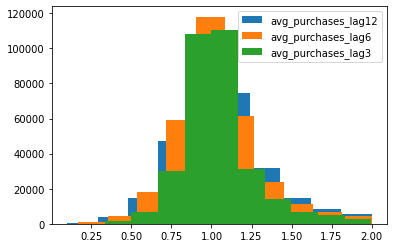

In [0]:
plt.hist(merch.loc[(merch['avg_purchases_lag12'] < 2), 'avg_purchases_lag12'], label='avg_purchases_lag12');
plt.hist(merch.loc[(merch['avg_purchases_lag6'] < 2), 'avg_purchases_lag6'], label='avg_purchases_lag6');
plt.hist(merch.loc[(merch['avg_purchases_lag3'] < 2), 'avg_purchases_lag3'], label='avg_purchases_lag3');
plt.legend();

Even all the distributions looks similar.

Therefore, all the distributions of features looks similar and we can ignore the merchant file for not further adding to the existing train and test files.
By adding `Merchant` file in to the train and test dataset will be not be effective in deciding the predicted value.

Why we are not considering the features for `Merchant`csv ?

Each independent feature should be different to each other to predict an output and also it is very important in playing a significant role in `feature selection`.